In [20]:
import os
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

#our files
import utils
from dataloader import FullImageDataset
from models import setup_model

In [21]:
args = utils.parse_arguments(False)
args.batch_size = 1
args.worker = 1
args.in_channels = 3
args.upsampled_image_size=224
args.upsampled_mask_size=224
args.normalizing_type= 'zscore'
args.model_type='vit_imagenet'
args.vit_size='base'
args.resume_training=True
args.checkpoint = './models/imagenet_vit_base_mt/end.pth'
args = utils.sanity_checks(args)

{'data_dir': '/scratch/kj1447/gracelab/dataset', 'model_dir': '/scratch/kj1447/gracelab/models/SWIN_FPN_low_LR', 'loss': 'BCE', 'alpha': 0.25, 'epochs': 250, 'batch_size': 16, 'workers': 16, 'train_ratio': 0.8, 'learning_rate': 0.0001, 'lookback': 10, 'seed': 42, 'resume_training': False, 'starting_epoch': 0, 'upsampled_image_size': 256, 'upsampled_mask_size': 64, 'in_channels': 3, 'normalizing_type': 'constant', 'normalizing_factor': 4000, 'model_type': 'swin', 'pretrained': True, 'checkpoint': None, 'use_timepoints': True, 'learned_upsampling': True, 'exp_name': 'SWIN_MI', 'exp_number': 1, 'vit_size': 'vit_base', 'pretrained_weights': 'Sentinel2_SwinB_MI_RGB', 'mask_2d': True}


In [22]:
torch.manual_seed(args.seed)
random.seed(args.seed)

In [23]:
#DATALOADER
geo_transform = None
color_transform=None

image_resize = transforms.Compose([transforms.Resize(args.upsampled_image_size,transforms.InterpolationMode.BICUBIC, antialias=True)])
mask_resize = transforms.Compose([transforms.Resize(args.upsampled_mask_size,transforms.InterpolationMode.NEAREST, antialias=True)])

image_dir = os.path.join(args.data_dir, 'image_stack')
mask_dir = os.path.join(args.data_dir, 'mask')

# for multi-image
if args.use_timepoints:
    with open("dataset/four_or_more_timepoints.pkl",'rb') as f:
        image_filenames = pickle.load(f)
else:
    image_filenames = os.listdir(image_dir)

In [24]:
random.Random(args.seed).shuffle(image_filenames)
train_set = image_filenames[:int(args.train_ratio*len(image_filenames))]
val_set = image_filenames[int(args.train_ratio*len(image_filenames)):]

train_dataset = FullImageDataset(args, image_files=train_set, geo_transforms=geo_transform, color_transforms= color_transform, image_resize=image_resize, mask_resize=mask_resize)
val_dataset = FullImageDataset(args, image_files=val_set, image_resize=image_resize, mask_resize=mask_resize,)

train_dataloader = data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory = True, num_workers = args.workers, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True,  pin_memory = True,  num_workers = args.workers, drop_last=True)


In [25]:
model = setup_model(args)

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
val_dataloader_iter = iter(val_dataloader)

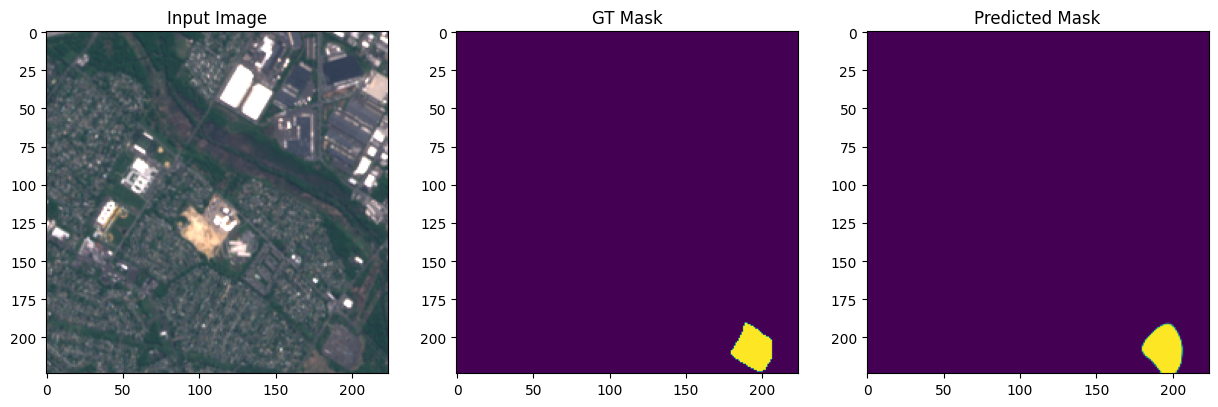

In [56]:
with torch.no_grad():
    model.eval()
    batch = next(val_dataloader_iter)
    data, target = batch[0].to(device).float(), batch[1].to(device)
    output,loss = model(data, target)

    if args.use_timepoints:
        data = data[:,0:3,:,:]
        
    if args.normalizing_type == 'zscore':
        data = data*args.stds[[3,2,1],:,:] + args.means[[3,2,1],:,:]
        data = torch.clip(data/3000,0,1)
        
    fig, axs = plt.subplots(1,3, figsize = (15,15))
    axs[0].imshow(data[0,[0,1,2],:,:].permute(1,2,0))
    axs[0].set_title("Input Image")
    axs[1].imshow(target[0].permute(1,2,0))
    axs[1].set_title("GT Mask")
    axs[2].imshow(output[0].permute(1,2,0))
    axs[2].set_title("Predicted Mask")